tempo: 0.4700605869293213


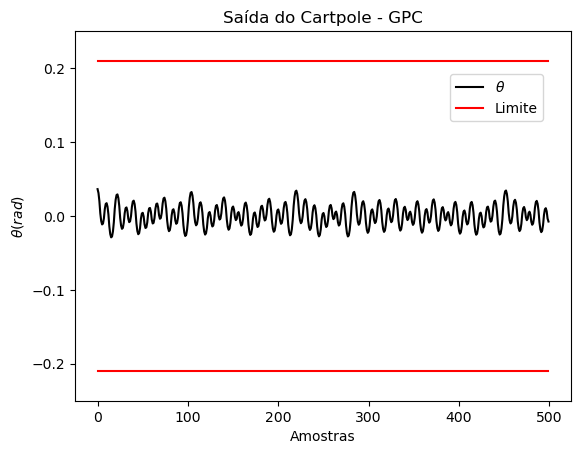

In [1]:
# Autor: Gabriel Bueno Leandro
# Título: Aplicação do GPC

# Importando as bibliotecas
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import gym
import imageio
import time

Hp = 4 # Definindo o horizonte de controle, que é igual o de predição
p = np.array([-2, 0, 2]) # Opções de acordo com o delta u
b =product(p, repeat=Hp) # Aplicação do método product

Possibilidades = [] # lista fazia para receber todas as combinações
for i in b: 
    Possibilidades.append(i) # Salvar todas as possibilidades
Matriz = np.zeros((len(Possibilidades), Hp)) # Matriz para organizar todas as possibilidades
for i in range (0, len(Possibilidades)):
    Matriz[i, :] = np.array(Possibilidades[i])

action = 1 # Inicia a ação como sendo 1, força para direita
Soma = np.ones(np.shape(Matriz))*action # Matriz que auxilia na obtenção do delta u
for i in range(0, np.shape(Matriz)[0]): # Salva as possibilidadas + matriz soma
    for j in range(0, np.shape(Matriz)[1]): 
        Soma[i, j] = Matriz[i, j] + Soma[i, j-1]
a = []
for i in range(0, np.shape(Matriz)[0]): # Elimina resposta que não atendem ao requisitos estabelidos
    if max(Soma[i, :])>=2 or min(Soma[i, :])<=-2:
        a.append(i)
Soma_p = np.delete(Soma, a, 0) # Deleta todos os delta u inválidos início
Matriz_p = np.delete(Matriz, a, 0) # Matriz para organizar todas as possibilidades

def delu_p(action, Hp):
    """Obtendo delta u

    Args:
        action (int): acão
        Hp (int): horizonte de predição que é igual o horizonte de controle

    Returns:
        Matriz_p (ndarray): Matriz com todos os delta u possível para cada ação
    """
    p = np.array([-2, 0, 2]) # Opções de acordo com o delta u
    b =product(p, repeat=Hp) # Aplicação do método product
    Possibilidades = [] # lista fazia para receber todas as combinações
    for i in b:
        Possibilidades.append(i) # Salvar todas as possibilidades
    Matriz = np.zeros((len(Possibilidades), Hp)) # Matriz para organizar todas as possibilidades
    for i in range (0, len(Possibilidades)):
        Matriz[i, :] = np.array(Possibilidades[i])
    Soma = np.ones(np.shape(Matriz))*action
    for i in range(0, np.shape(Matriz)[0]):
        for j in range(0, np.shape(Matriz)[1]):
            Soma[i, j] = Matriz[i, j] + Soma[i, j-1]
    a = []
    for i in range(0, np.shape(Matriz)[0]):
        if max(Soma[i, :])>=2 or min(Soma[i, :])<=-2:
            a.append(i)
    Soma_p = np.delete(Soma, a, 0)
    Matriz_p = np.delete(Matriz, a, 0)
    return Matriz_p

def Ta(a1, a2, a3, N):
    """Monta e retorna a matriz tau_a invertida

    Args:
        a1 (float): Termo modelo ARX y(k-1)
        a2 (float): Termo modelo ARX y(k-2)
        a3 (float): Termo modelo ARX y(k-2)
        N (int): Horizonte de controle

    Returns:
        ndarray : Matriz tau_a invertida
    """
    Ta = np.zeros((N, N))
    for i in range(0, N):
        Ta[i, i] = 1
        if i+1<N:
            Ta[i+1, i] = a1
        if i+2<N:
            Ta[i+2, i] = a2
        if i+3<N:
            Ta[i+3, i] = a3
    return np.linalg.inv(Ta)

def Sa(a1, a2, a3, N):
    """Monta e retorna a matriz sa

    Args:
        a1 (float): Termo modelo ARX y(k-1)
        a2 (float): Termo modelo ARX y(k-2)
        a3 (float): Termo modelo ARX y(k-2)
        N (int): Horizonte de controle

    Returns:
        ndarray : Matriz sa
    """
    Sa = np.zeros((N, 3))
    Sa[0, :] = a1, a2, a3
    Sa[1, 0:2] = a2, a3
    Sa[2, 0] = a3
    return Sa

def Tb(b1, b2, N):
    """Monta e retorna a matriz tau_b

    Args:
        b1 (float): Termo modelo ARX u(k-1)
        b2 (float): Termo modelo ARX u(k-2)
        N (int): Horizonte de predição

    Returns:
        ndarray: Matriz tau_b
    """
    b2 = 0
    Tb = np.zeros((N, N))
    for i in range(0, N):
        Tb[i, i] = b1
        if i+1<N:
            Tb[i+1, i] = b2
    return Tb

def predict(y, k, Matriz, action):
    """Aplicação do controle preditivo generalizado

    Args:
        y (ndarray): Array contendo os valores de ângulo
        k (int): Instante em ambiente se encontra, horizonte deslizante
        Matriz (ndarray): Matriz com todas as possibilidades de delta u
        action (int): Delta u inicial, o que é somado a ação

    Returns:
        int: Delta u inicial, o que é somado a ação
    """
    a1 = -3 # y(k-1)
    a2 = 2.99367 # y(k-2)
    a3 = -.99367 # y(k-3)
    b1 = -.00583 # u(k-1)
    b2 = 0 # u(k-2)
    Taa = Ta(a1, a2,a3, Hp) # Monta a matriz np.linalg.inv(tau_a)
    Tba = Tb(b1, b2, Hp) # Monta a matriz tau_b
    Saa = Sa(a1, a2,a3, Hp) # Monta a matriz s_a
    Matriz = delu_p(action, Hp) # Todas os deltas possíveis devido a ação
    yp = np.array([y[k], y[k-1], y[k-2]]).reshape(-1,1)
    soma = []
    G = Taa.dot(Tba)
    f = Taa.dot(Saa)
    for i in range(0, np.shape(Matriz)[0]):
        yo = (G.dot(Matriz[i, :].reshape(-1,1))-f.dot(yp))
        soma.append(float(abs(sum(yo))))
    return Matriz[soma.index(min(soma)),:]

env = gym.make("CartPole-v1", render_mode="rgb_array") # Inicio do ambiente e o seu modo de rederinzação
observation, info = env.reset(seed=42) # Reseta o ambiente e estabelece as condições iniciais
samples = 500 # Número de amostras 
y = np.zeros(samples) # Array para salvar o ângulo 
u = np.zeros(samples) # Array para salvar a entrada do CartPole
us = np.ones(samples) # Array para salvar a entrada da Função de Transferência
va = np.zeros(samples) # Array para salvar a velocidade angular
action = 1 # Definição ação inicial, pode ser 1 ou 0
c =[] # Lista para salvar o término de cada episódio
inicio = time.time() # Início da contagem de tempo
for i in range(samples): # Percorre todas as amostras
    observation, reward, terminated, truncated, info = env.step(action) # Aplica a ação
    u[i] = action # Salva a ação (CartPole) no array u
    y[i] = observation[2] # Salva o ângulo no array y
    va[i] = observation[1] # Salva a velocidade angular no array va
    if u[i]==0:
        us[i] = -1 # Adaptando a entrada para a Função de Transferência
    if i>1: # Verifica se há condições iniciais para chamar o GPC
        if action==0:
            action = -1
        a = predict(y, i, Matriz, action) # Calcula a ação devido ao GPC
    action = int(a[0]+action) # Soma o delta u a u
    if action==-1:
        action = 0
    if terminated or truncated:
        observation, info = env.reset() # Reseta o ambiente
        c.append(i) # Salva o amostra quando o episódio termina
env.close()
fime = time.time()
tempo_decorrido = fime - inicio # Calcula o tempo decorrido
print('tempo:', tempo_decorrido)
plt.plot(y,'k', label='$\\theta$')
plt.plot(np.ones(len(y))*.2095, 'r', label='Limite')
plt.plot(np.ones(len(y))*-.2095,'r')
plt.legend()
plt.yticks([-0.2, -0.1, 0, 0.1, 0.2])
plt.ylim(-.25, .25)
plt.legend(bbox_to_anchor=(0.85, 0.82), loc='center')
plt.xlabel('Amostras')
plt.ylabel('$\\theta (rad)$')
plt.title('Saída do Cartpole - GPC')
plt.show()

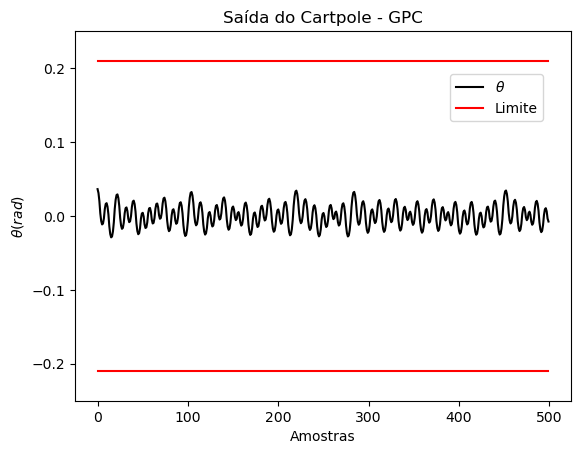

In [2]:
plt.rcParams['savefig.dpi'] = 2000  # 300 dpi (pontos por polegada
#plt.plot(np.zeros(len(y)), 'b', label='Referência')
plt.plot(y,'k', label='$\\theta$')
plt.plot(np.ones(len(y))*.2095, 'r', label='Limite')
plt.plot(np.ones(len(y))*-.2095,'r')
plt.legend()
plt.yticks([-0.2, -0.1, 0, 0.1, 0.2])
plt.ylim(-.25, .25)
plt.legend(bbox_to_anchor=(0.85, 0.82), loc='center')
plt.xlabel('Amostras')
plt.ylabel('$\\theta (rad)$')
plt.title('Saída do Cartpole - GPC')
plt.savefig('cpgpc.png', bbox_inches='tight', pad_inches=0.1)

tempo: 0.008538484573364258


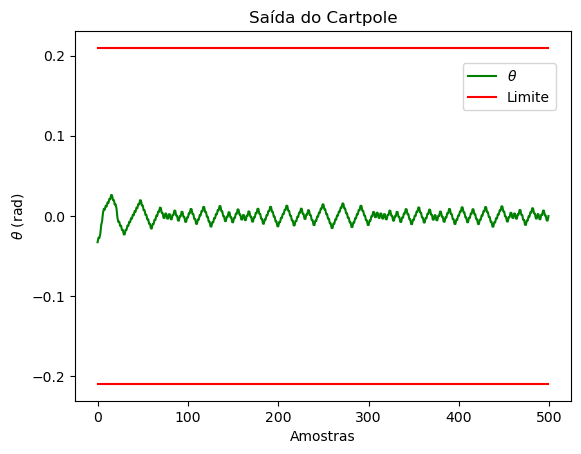

In [3]:
# Autor: Gabriel Bueno Leandro
# Título: Aplicação do PID

# Importando as bibliotecas
import gym
from matplotlib import pyplot as plt
import numpy as np
from time import sleep
import time

env = gym.make("CartPole-v1", render_mode='rgb_array') # Importando o ambiente CartPole
observation = env.reset(seed=87) # Reinicia o ambiente de simulação 
samples = 500 # Selecione o número de amostras
Kp = 0.5 # Termo Proporcional
Ki = 0.25 # Termo Integral
Kd = 0.125 # Termo Derivativo
force = 0 # Entrada do sistema, aqui definida como força
integral = 0 # O termo que receberá o somatório do termo integral
y = np.zeros(samples) # Array para salvar o ângulo do pêndulo
u = np.zeros(samples) # Array para salvar a ação/entrada do pêndulo
va = np.zeros(samples) # Array para salvar a velocidade angular do pêndulo
inicio = time.time() # Início da contagem do tempo 
for _ in range(samples): # Percorre todos os episódios
    #env.render() # Renderiza o ambiente
    observation, reward, done, info, aux = env.step(force) # Aplica a entrada ao sistema
    u[_] = force # Salva a entrada no vetor u
    y[_] = observation[2] # Salva o ângulo no vetor y
    va[_] = observation[1] # Salva a velocidade angular no vetor va
    velocity = observation[1] # Salva a velocidade no int velocity
    angle = observation[2] # Salva o ângulo no int angle
    angular_velocity = observation[3] # Salva a velocidade ângular no int angular_velocity
    integral = integral + angle # Termo integral, para isso usa um somatório
    F = Kp*(angle) + Kd*(angular_velocity) + Ki*(integral) # Aplicação do PID
    force = 1 if F > 0 else 0 # Se F é positivo force recebe 1, se negativo F = 0
    if done: # Verifica o término
        observation = env.reset() # Reseta o ambiente
        integral = 0 # A cada novo episódio, o termo integral deve zerar
env.close() # Encerra o ambiente
fime = time.time() # Encerra a contagem de tempo
tempo_decorrido = fime - inicio # Calcula o tempo decorrido
print('tempo:', tempo_decorrido)
plt.figure(1)
plt.plot(y, 'g', label=r'$\theta$')
plt.plot(.2095*np.ones(len(u)),'r')
plt.plot(-.2095*np.ones(len(u)),'r', label='Limite')
plt.legend(bbox_to_anchor=(.875, .85), loc='center')
plt.ylabel(r'$\theta$ (rad)')
plt.xlabel('Amostras')
plt.title('Saída do Cartpole')

plt.show()

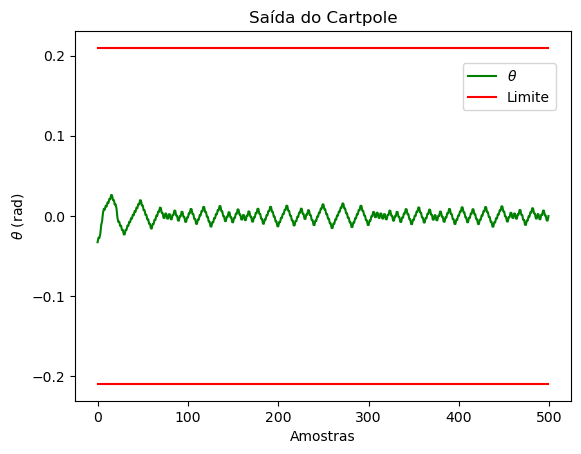

In [4]:
plt.figure(1)
plt.rcParams['savefig.dpi'] = 2000  # 300 dpi (pontos por polegada
#plt.plot(np.zeros(len(y)), 'b', label='Referência')
plt.plot(y, 'g', label=r'$\theta$')
plt.plot(.2095*np.ones(len(u)),'r')
plt.plot(-.2095*np.ones(len(u)),'r', label='Limite')
plt.legend(bbox_to_anchor=(.875, .85), loc='center')
plt.ylabel(r'$\theta$ (rad)')
plt.xlabel('Amostras')
plt.title('Saída do Cartpole')
plt.savefig('cppid.png', bbox_inches='tight', pad_inches=0.1)

Discrete(4)
Episode finished after 0 timesteps
324
Episode finished after 1 timesteps
711
Episode finished after 2 timesteps
818
Episode finished after 3 timesteps
1075
Episode finished after 4 timesteps
1227
Episode finished after 5 timesteps
1509
Episode finished after 6 timesteps
1776
Episode finished after 7 timesteps
2195
Episode finished after 8 timesteps
2293
Episode finished after 9 timesteps
2643
Episode finished after 10 timesteps
3027
Episode finished after 11 timesteps
3528
Episode finished after 12 timesteps
4000
Episode finished after 13 timesteps
4280
Episode finished after 14 timesteps
4641
Episode finished after 15 timesteps
4937
Episode finished after 16 timesteps
5351
Episode finished after 17 timesteps
5436
Episode finished after 18 timesteps
5562
Episode finished after 19 timesteps
5871
Episode finished after 20 timesteps
6253
Episode finished after 21 timesteps
6768
Episode finished after 22 timesteps
7424
Episode finished after 23 timesteps
7770
Episode finished 

Episode finished after 194 timesteps
59468
Episode finished after 195 timesteps
59736
Episode finished after 196 timesteps
60028
Episode finished after 197 timesteps
60359
Episode finished after 198 timesteps
60435
Episode finished after 199 timesteps
60513
Episode finished after 200 timesteps
60620
Episode finished after 201 timesteps
61036
Episode finished after 202 timesteps
61383
Episode finished after 203 timesteps
61690
Episode finished after 204 timesteps
61981
Episode finished after 205 timesteps
62094
Episode finished after 206 timesteps
62186
Episode finished after 207 timesteps
62655
Episode finished after 208 timesteps
62956
Episode finished after 209 timesteps
63266
Episode finished after 210 timesteps
63368
Episode finished after 211 timesteps
63614
Episode finished after 212 timesteps
63937
Episode finished after 213 timesteps
64303
Episode finished after 214 timesteps
64605
Episode finished after 215 timesteps
64919
Episode finished after 216 timesteps
65059
Episode fin

Episode finished after 387 timesteps
117225
Episode finished after 388 timesteps
117674
Episode finished after 389 timesteps
117958
Episode finished after 390 timesteps
118348
Episode finished after 391 timesteps
118641
Episode finished after 392 timesteps
118907
Episode finished after 393 timesteps
118987
Episode finished after 394 timesteps
119254
Episode finished after 395 timesteps
119599
Episode finished after 396 timesteps
120092
Episode finished after 397 timesteps
120639
Episode finished after 398 timesteps
120959
Episode finished after 399 timesteps
121060
Episode finished after 400 timesteps
121354
Episode finished after 401 timesteps
121655
Episode finished after 402 timesteps
122222
Episode finished after 403 timesteps
122434
Episode finished after 404 timesteps
123008
Episode finished after 405 timesteps
123436
Episode finished after 406 timesteps
123763
Episode finished after 407 timesteps
124135
Episode finished after 408 timesteps
124394
Episode finished after 409 times

Episode finished after 575 timesteps
173169
Episode finished after 576 timesteps
173452
Episode finished after 577 timesteps
174476
Episode finished after 578 timesteps
174714
Episode finished after 579 timesteps
174968
Episode finished after 580 timesteps
175348
Episode finished after 581 timesteps
175668
Episode finished after 582 timesteps
175965
Episode finished after 583 timesteps
176063
Episode finished after 584 timesteps
176441
Episode finished after 585 timesteps
176737
Episode finished after 586 timesteps
177116
Episode finished after 587 timesteps
177417
Episode finished after 588 timesteps
177518
Episode finished after 589 timesteps
178071
Episode finished after 590 timesteps
178686
Episode finished after 591 timesteps
178759
Episode finished after 592 timesteps
178841
Episode finished after 593 timesteps
178951
Episode finished after 594 timesteps
179069
Episode finished after 595 timesteps
179151
Episode finished after 596 timesteps
179435
Episode finished after 597 times

Episode finished after 767 timesteps
230308
Episode finished after 768 timesteps
230659
Episode finished after 769 timesteps
230754
Episode finished after 770 timesteps
231090
Episode finished after 771 timesteps
231176
Episode finished after 772 timesteps
231461
Episode finished after 773 timesteps
231731
Episode finished after 774 timesteps
232173
Episode finished after 775 timesteps
232577
Episode finished after 776 timesteps
233049
Episode finished after 777 timesteps
233438
Episode finished after 778 timesteps
233758
Episode finished after 779 timesteps
234264
Episode finished after 780 timesteps
234596
Episode finished after 781 timesteps
234883
Episode finished after 782 timesteps
235267
Episode finished after 783 timesteps
235591
Episode finished after 784 timesteps
235876
Episode finished after 785 timesteps
236159
Episode finished after 786 timesteps
236512
Episode finished after 787 timesteps
236787
Episode finished after 788 timesteps
237119
Episode finished after 789 times

Episode finished after 956 timesteps
287169
Episode finished after 957 timesteps
287538
Episode finished after 958 timesteps
287820
Episode finished after 959 timesteps
288120
Episode finished after 960 timesteps
288455
Episode finished after 961 timesteps
288577
Episode finished after 962 timesteps
289181
Episode finished after 963 timesteps
289266
Episode finished after 964 timesteps
289558
Episode finished after 965 timesteps
289734
Episode finished after 966 timesteps
289982
Episode finished after 967 timesteps
290276
Episode finished after 968 timesteps
290795
Episode finished after 969 timesteps
291099
Episode finished after 970 timesteps
291360
Episode finished after 971 timesteps
291892
Episode finished after 972 timesteps
292520
Episode finished after 973 timesteps
293145
Episode finished after 974 timesteps
293450
Episode finished after 975 timesteps
293692
Episode finished after 976 timesteps
293795
Episode finished after 977 timesteps
294084
Episode finished after 978 times

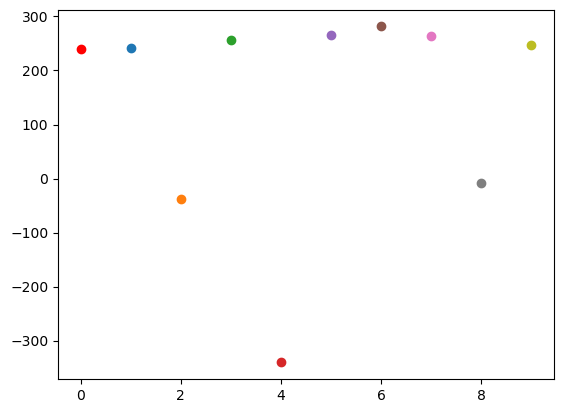

In [5]:
# Autor: Gabriel Bueno Leandro
# Título: Aplicação do PD

# Importando as bibliotecas
import gym
import tempfile
import numpy as np
import time
import matplotlib.pyplot as plt
# Definindo o ambiente
tdir = tempfile.mkdtemp()
env = gym.make('LunarLander-v2', render_mode='rgb_array')
print (env.action_space)
p = []

def pid(state):
    """ calculates settings based on pid control """
    # PID parameters
    kp_alt = 9.0565  # proportional altitude
    kd_alt = -9.9488  # derivative altitude
    kp_ang = 11.9271  # proportional angle
    kd_ang = -5.0963  # derivative angle
    
    # Calculate setpoints (target values)
    alt_tgt = np.abs(state[0])
    ang_tgt = (.25*np.pi)*(state[0]+state[2])
    if ang_tgt >  0.785: ang_tgt =  0.785
    if ang_tgt < -0.785: ang_tgt = -0.785

    # Calculate error values
    alt_error = (alt_tgt - state[1])
    ang_error = (ang_tgt - state[4])
    
    # Use PID to get adjustments
    alt_adj = kp_alt*alt_error + kd_alt*state[3]
    ang_adj = kp_ang*ang_error + kd_ang*state[5]
    if state[6] or state[7]:
        ang_adj  = 0
        ang_adj = (state[3])*kd_alt
    action = 0
    if alt_adj > 0.5*np.abs(ang_adj) and alt_adj > 0.2: action = 2 #0.175
    elif ang_adj < -.1: action = 3#.25
    elif ang_adj > +.1: action = 1
    return action

r = []
x = []
y = []
vx = []
vy = []
th = []
vt = []
g = []
cont = 0
ooo = 0
inicio = time.time()
# 100 trials for landing
for t in range(1000):
    observation = env.reset()
    observation = observation[0]
    while 1:
        #env.render()
        cont+=1
        #print(observation)
        # select action using pid method
        action = pid(observation)
        observation, reward, done, info, a = env.step(action)
        r.append(reward)
        if reward==100:
            ooo+=1
        x.append(observation[0])
        y.append(observation[1])
        vx.append(observation[2])
        vy.append(observation[3])
        th.append(observation[4])
        vt.append(observation[5])
        if done:
            print("Episode finished after {} timesteps".format(t))
            g.append(cont)
            print(cont)
            break

env.close()
fim = time.time()
# Calcula o tempo decorrido
tempo_decorrido = fim - inicio

print(f"Tempo decorrido: {tempo_decorrido} segundos")

print(ooo)
d = 0
soma = np.zeros(10)
soma[0] = sum(r[:g[0]])
plt.plot(0, sum(r[:g[0]]), 'or--')
for i in range(0, 9):
    plt.plot(i+1, sum(r[g[i]:g[i+1]]), 'o--')
    soma[i+1] = sum(r[g[i]:g[i+1]])
    if sum(r[g[i]:g[i+1]])>200:
        d+=1
print(d)

735
713


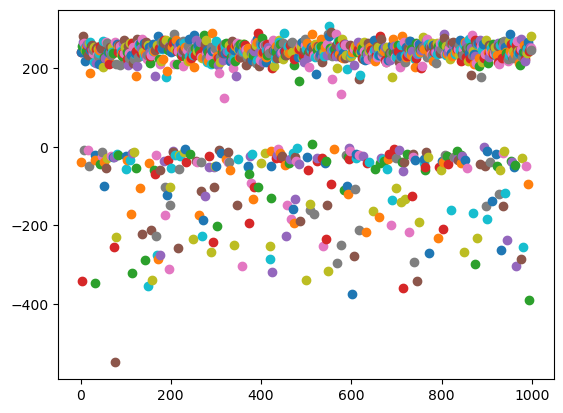

In [6]:

print(ooo)
d = 0
soma = np.zeros(1000)
soma[0] = sum(r[:g[0]])
plt.plot(0, sum(r[:g[0]]), 'or--')
for i in range(0, 999):
    plt.plot(i+1, sum(r[g[i]:g[i+1]]), 'o--')
    soma[i+1] = sum(r[g[i]:g[i+1]])
    if sum(r[g[i]:g[i+1]])>200:
        d+=1
print(d)

In [ ]:
# Autor: Gabriel Bueno Leandro
# Título: Aplicação do PD

# Importando as bibliotecas
import gym
import tempfile
import numpy as np
import time
import matplotlib.pyplot as plt
# Definindo o ambiente
tdir = tempfile.mkdtemp()
env = gym.make("LunarLander-v2", render_mode="rgb_array")
#env = gym.make("LunarLander-v2", render_mode="human", enable_wind=True, wind_power=3.5, gravity=-11.5, turbulence_power=1)
#env = gym.make("LunarLander-v2", render_mode="human", gravity=-1.63)
p = []

def pid(state):
    """Agoritmo controle PID

    Args:
        state (ndarray): Estado da sonda lunar adivindo do espaço de observação do Lunar Lander

    Returns:
        int: Saída do controlador PID
    """
    # Parâmetros do PID
    kp_alt = 9.0565  # Proporcional da altitude
    kd_alt = -9.9488  # Deritivo da altitude
    kp_ang = 11.9271  # Proporcional do ângulo
    kd_ang = -5.0963  # Derivativo do ângulo
    
    # Cálculo dos setpoints: ângulo e altitude
    alt_tgt = np.abs(state[0]) # |x| => módulo de x
    ang_tgt = (.25*np.pi)*(state[0]+state[2]) # A nave deve apontar em sentido ao objetivo
    if ang_tgt >  0.5: ang_tgt =  0.5 # Limitação de teto positivo
    if ang_tgt < -0.5: ang_tgt = -0.5 # Limitação de teto negativo

    # Cálculo dos erros
    alt_error = (alt_tgt - state[1]) # Erro de altitude
    ang_error = (ang_tgt - state[4]) # Erro angular
    
    # Use o PD para obter ajustes
    alt_adj = kp_alt*alt_error + kd_alt*state[3] # PD altitude
    ang_adj = kp_ang*ang_error + kd_ang*state[5] # PD ângulo
    if state[6] or state[7]: # Verifica se um dos pés está em contato com o solo
        ang_adj  = 0 # Se sim,  ang_adj é zero
        ang_adj = (state[3])*kd_alt # O multiplica pelo parâmetro derivativo da altitude
    action = 0 # Início, setando a ação em 0
    g = 0.2 # Inícia o múltiplo da altitude 
    if state[1]<0.65: g = (state[1]-state[3]+.975)# Se, y<0,65 o g asume valor maior
    if state[1]<0.05: g = (state[1]-state[3]+0.05)# Se, y<0,05 há uma desaceleração
    if alt_adj*g > np.abs(ang_adj) and alt_adj > 0.05: action = 2 # Verifica o acionamento do propulsor principal
    elif ang_adj < -.05: action = 3 # Verifica o acionamento do propulsor direito (auxiliar)
    elif ang_adj > +.05: action = 1 # Verifica o acionamento do propulsor esquerdo (auxiliar)
    if sum(state[6:])==2 and abs(state[0]<.125): action = 0  # Se ambos os pés estão no solo e a sonda está na plataforma
    return action # Retorna a ação

r = [] # Lista para salvar a recompensa
x = [] # Lista para salvar a posição x
y = [] # Lista para salvar a posição x
vx = [] # Lista para salvar a velocidade linear em x
vy = [] # Lista para salvar a velocidade linear em y
th = [] # Lista para salvar o ângulo
vt = [] # Lista para salvar a velocidade angular
g = [] # Salva o fim do episódio
cont = 0 # Início do contador do episódio
ooo = 0 # Início do contador de pouso
inicio = time.time() # Início da contagem de tempo
num_ep = 3 # Define o número de episódios
for t in range(1000): # Vai até o episódio definido
    observation = env.reset() # Criando o ambiente LunarLander e renderização, onde você pode alterar 'human' para 'rgb_array' ou 'ansi' dependendo do modo que deseja usar
    observation = observation[0] # Salva o espaço de observação
    while 1: # Verifica a continuidade, sempre continuando só para devido ao break da linha 91
        env.render() # Renderização
        cont+=1 # Contador recebe mais 1
        action = pid(observation) # Chama a função PID
        observation, reward, done, info, a = env.step(action) # Aplicação da ação de controle
        r.append(reward) # Salva a recompensa
        if reward==100: # Se pousar (reward==100)
            ooo+=1 # Contador de pousos
        x.append(observation[0]) # Salva a posição x
        y.append(observation[1]) # Salva a posição y
        vx.append(observation[2]) # Salva a velocidade linear em x
        vy.append(observation[3]) # Salva a velocidade linear em y
        th.append(observation[4]) # Salva o ângulo
        vt.append(observation[5]) # Salva a velocidade angular
        if done: # Verifica o término do episódio
            print("Episódio número: ", t+1)  # Printa a cada fim de episódio
            g.append(cont) # Salva o fim do episódio
            break # Para o algoritmo

env.close() # Encerra o ambiente
fim = time.time() # Marca o fim da contagem do tempo
tempo_decorrido = fim - inicio # Calcula o tempo decorrido
print(f"Tempo decorrido: {tempo_decorrido} segundos") # Printa o tempo decorrido
print("Número de pousos: ", ooo) # Printa o número de pousos com sucesso
d = 0 # Conta os pesos com +200 pontos
soma = np.zeros(num_ep) # Salva a soma para cada episódio
soma[0] = sum(r[:g[0]]) # Salva a soma do episódio inicial
if soma[0]>=200: # Verifica se a soma é mais de 200 pontos para ep zero
    d = 1 # Inicia o contador
for i in range(0, num_ep-1): # Percorre os episódios realizados
    soma[i+1] = sum(r[g[i]:g[i+1]]) # Soma para cada episódio
    if sum(r[g[i]:g[i+1]])>200: # Verifica se a soma é mais de 200 pontos para os eps restante
        d+=1 # O contador soma mais um a d
# Mostrando os resultados
plt.plot(np.arange(1, 4), soma, 'ko',  label='Episódio')
print("Número de pousos com +200 pontos: ", d)
print("Média de pontuação: ", np.mean(soma))
print("Número de etapas: ", len(x))
plt.plot(np.arange(1, 4), np.ones(3)*200, 'r',  linewidth=2.5, label='+200 pontos')
plt.ylabel('Pontuação')
plt.xlabel('Episódios')
plt.title('Validação - PD')
plt.legend()
plt.show()


Episódio número:  1
Episódio número:  2
Episódio número:  3
Episódio número:  4
Episódio número:  5
Episódio número:  6
Episódio número:  7
Episódio número:  8
Episódio número:  9
Episódio número:  10
Episódio número:  11
Episódio número:  12
Episódio número:  13
Episódio número:  14
Episódio número:  15
Episódio número:  16
Episódio número:  17
Episódio número:  18
Episódio número:  19
Episódio número:  20
Episódio número:  21
Episódio número:  22
Episódio número:  23
Episódio número:  24
Episódio número:  25
Episódio número:  26
Episódio número:  27
Episódio número:  28
Episódio número:  29
Episódio número:  30
Episódio número:  31
Episódio número:  32
Episódio número:  33
Episódio número:  34
Episódio número:  35
Episódio número:  36
Episódio número:  37
Episódio número:  38
Episódio número:  39
Episódio número:  40
Episódio número:  41
Episódio número:  42
Episódio número:  43
Episódio número:  44
Episódio número:  45
Episódio número:  46
Episódio número:  47
Episódio número:  48
E